In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import cv2
import numpy as np

image shape: (410, 615, 3)


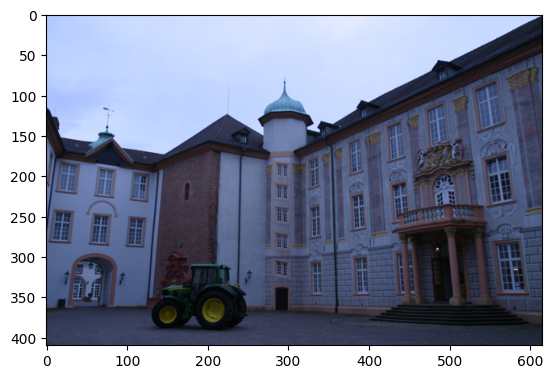

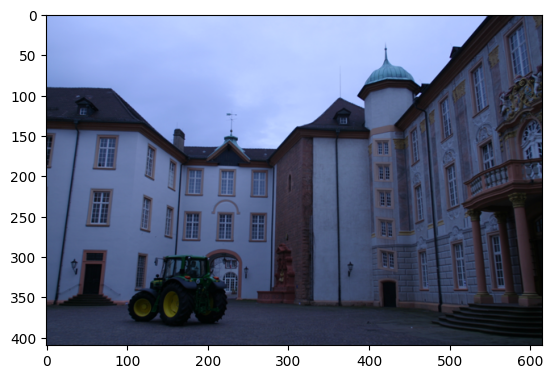

In [10]:
# load the images
im_left = cv2.imread('../data/0014_2.png')
print("image shape:", im_left.shape)
# plt.imshow(np.transpose(im_left,[2,0,1]))
plt.imshow(im_left[:, :, ::-1])
plt.figure()
im_right = cv2.imread('../data/0017_2.png')
plt.imshow(im_right[:, :, ::-1])
images = [im_left, im_right]

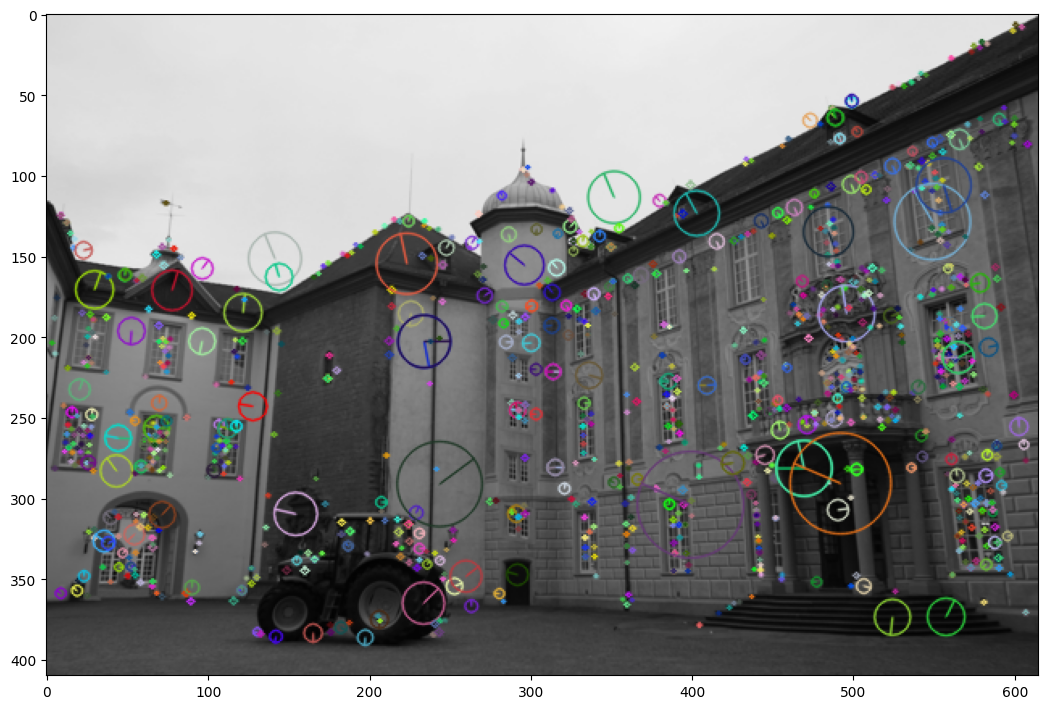

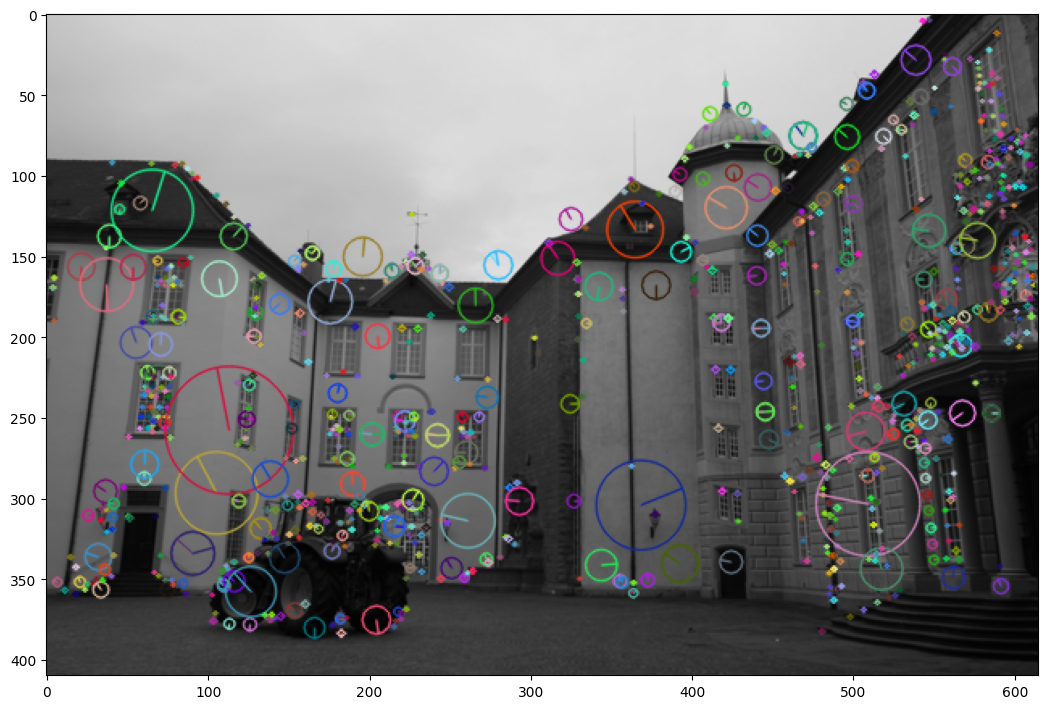

In [20]:
""" Detects SIFT features in all of the images
"""
keypoints = []
descriptions = []
for im in images:
  gray= cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(gray,None)

  keypoints.append(kp)
  descriptions.append(des)

  plt.figure(figsize=(6.4*2, 4.8*2))
  out_im = cv2.drawKeypoints(gray,kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


  plt.imshow(out_im)

num matches 598


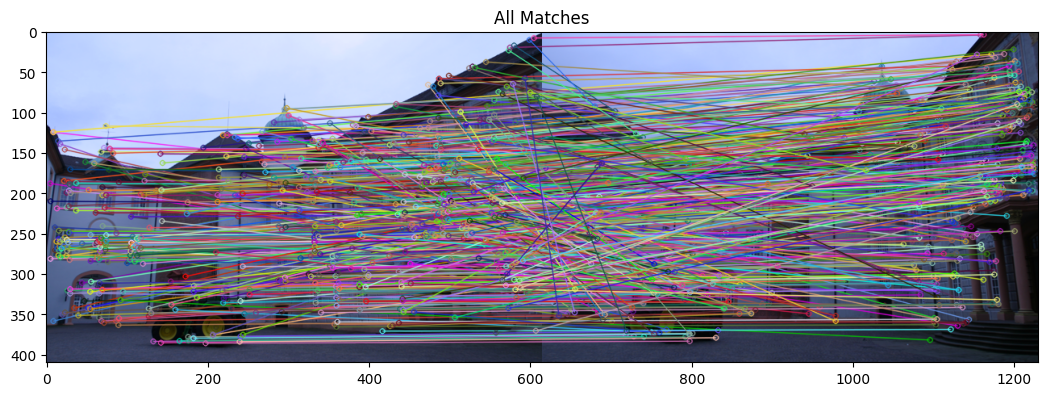

In [21]:
""" Matches the detected keypoints between the images
"""

bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(descriptions[0], descriptions[1])

print("num matches", len(matches))


matched_image = cv2.drawMatches(images[0][:, :, ::-1], keypoints[0], images[1][:, :, ::-1], keypoints[1], matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("All Matches")
plt.imshow(matched_image)


In [30]:
print(matches[0].distance)
print(matches[0].imgIdx)
print(matches[0].queryIdx)
print(matches[0].trainIdx)
print(keypoints[0][matches[0].queryIdx].pt[0])


272.87542724609375
0
1
733
4.903565406799316


In [31]:
""" Compute calibrated coordinates
"""

# For the satsok castle images
f1 = f2 = 552
u0 = 307.5
v0 = 205

K = np.array([[f1, 0, u0],
              [0, f2, v0],
              [0, 0, 1]])


uncalibrated_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in matches]     # N x 3
uncalibrated_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in matches]     # N x 3

uncalibrated_1 = np.array(uncalibrated_1).T     # 3 x N
uncalibrated_2 = np.array(uncalibrated_2).T     # 3 x N

k_inv = np.linalg.inv(K)

# camera coord
calibrated_1 = np.matmul(k_inv, uncalibrated_1).T
calibrated_2 = np.matmul(k_inv, uncalibrated_2).T


In [33]:
from lse import least_squares_estimation

E_least = least_squares_estimation(calibrated_1, calibrated_2)
print("E least", E_least)

E least [[ 0.16576508 -0.26425128  0.49683621]
 [-0.24883257 -0.94012561 -0.04428804]
 [ 0.35380308  0.00178721  0.76351288]]


E_ransac [[ 0.00905853  0.16687283 -0.05660131]
 [-0.58114853 -0.02806003  0.81133061]
 [ 0.1440723  -0.9736465   0.05783624]]
Num inliers (175,)


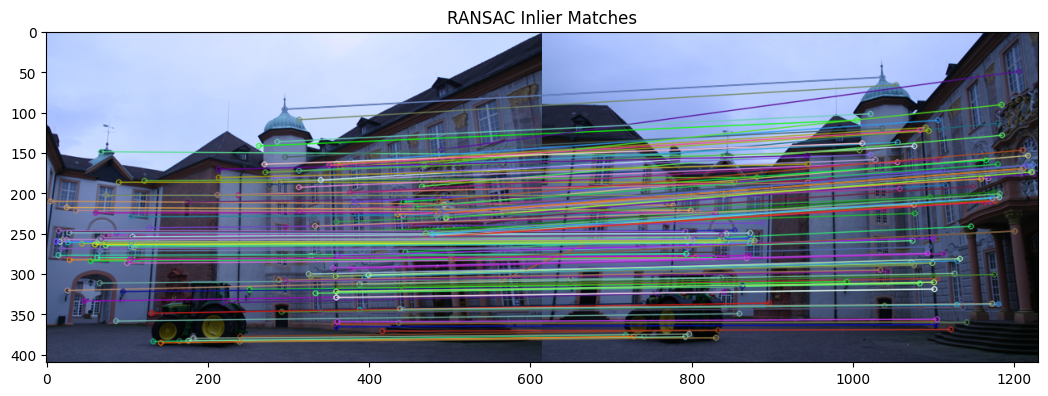

In [35]:
from ransac import ransac_estimator

# running this cell will take a while!!!

E_ransac, inliers = ransac_estimator(calibrated_1, calibrated_2)
print("E_ransac", E_ransac)
print("Num inliers", inliers.shape)

inlier_matches = [matches[i] for i in inliers]

matched_image = cv2.drawMatches(images[0][:, :, ::-1],
                                keypoints[0],
                                images[1][:, :, ::-1],
                                keypoints[1],
                                inlier_matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("RANSAC Inlier Matches")
plt.imshow(matched_image)

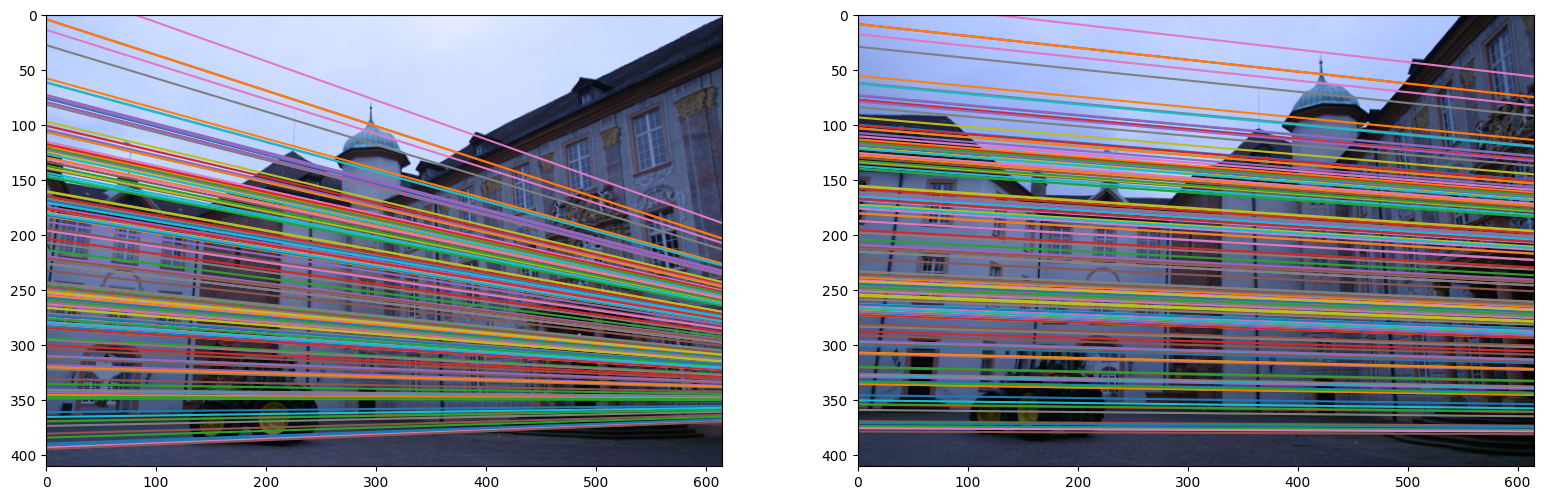

In [37]:
from plot_epi import plot_epipolar_lines

uncalibrated_inliers_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_1 = np.array(uncalibrated_inliers_1).T
uncalibrated_inliers_2 = np.array(uncalibrated_inliers_2).T

plot_epipolar_lines(images[0], images[1], uncalibrated_inliers_1, uncalibrated_inliers_2, E_ransac, K)

In [47]:
from pose import pose_candidates_from_E

transform_candidates = pose_candidates_from_E(E_ransac)
print("transform_candidates", transform_candidates)
for c in transform_candidates:
  print(np.linalg.det(c['R']))

np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]]).T

transform_candidates [{'T': array([-0.98431077, -0.0567597 , -0.16706478]), 'R': array([[-0.68305937, -0.20107775, -0.7021379 ],
       [-0.18575693,  0.97757071, -0.09924647],
       [-0.70634571, -0.06263575,  0.70509042]])}, {'T': array([-0.98431077, -0.0567597 , -0.16706478]), 'R': array([[-0.89359327, -0.09992568, -0.43761389],
       [ 0.09484019, -0.9949279 ,  0.03352336],
       [ 0.43874412,  0.01154713, -0.89853785]])}, {'T': array([0.98431077, 0.0567597 , 0.16706478]), 'R': array([[-0.68305937, -0.20107775, -0.7021379 ],
       [-0.18575693,  0.97757071, -0.09924647],
       [-0.70634571, -0.06263575,  0.70509042]])}, {'T': array([0.98431077, 0.0567597 , 0.16706478]), 'R': array([[-0.89359327, -0.09992568, -0.43761389],
       [ 0.09484019, -0.9949279 ,  0.03352336],
       [ 0.43874412,  0.01154713, -0.89853785]])}]
-1.0000000000000002
-1.0000000000000002
-1.0000000000000002
-1.0000000000000002


array([[ 0,  1,  0],
       [-1,  0,  0],
       [ 0,  0,  1]])

In [39]:
def plot_reconstruction(P1, P2, T, R):
  P1trans = (R @ P1.T).T + T

  plt.figure(figsize=(6.4*2, 4.8*2))
  ax = plt.axes()
  ax.set_xlabel('x')
  ax.set_ylabel('z')

  for i in range(P1.shape[0]):
    plt.plot([0, P2[i, 0]], [0, P2[i, 2]], 'bs-')
    plt.plot([T[0], P1trans[i, 0]], [T[2], P1trans[i, 2]], 'ro-')
  plt.plot([0], [0], 'bs')
  plt.plot([T[0]], [T[2]], 'ro')

best 23 (598,)
not best 0
best 575 (598,)
not best 4


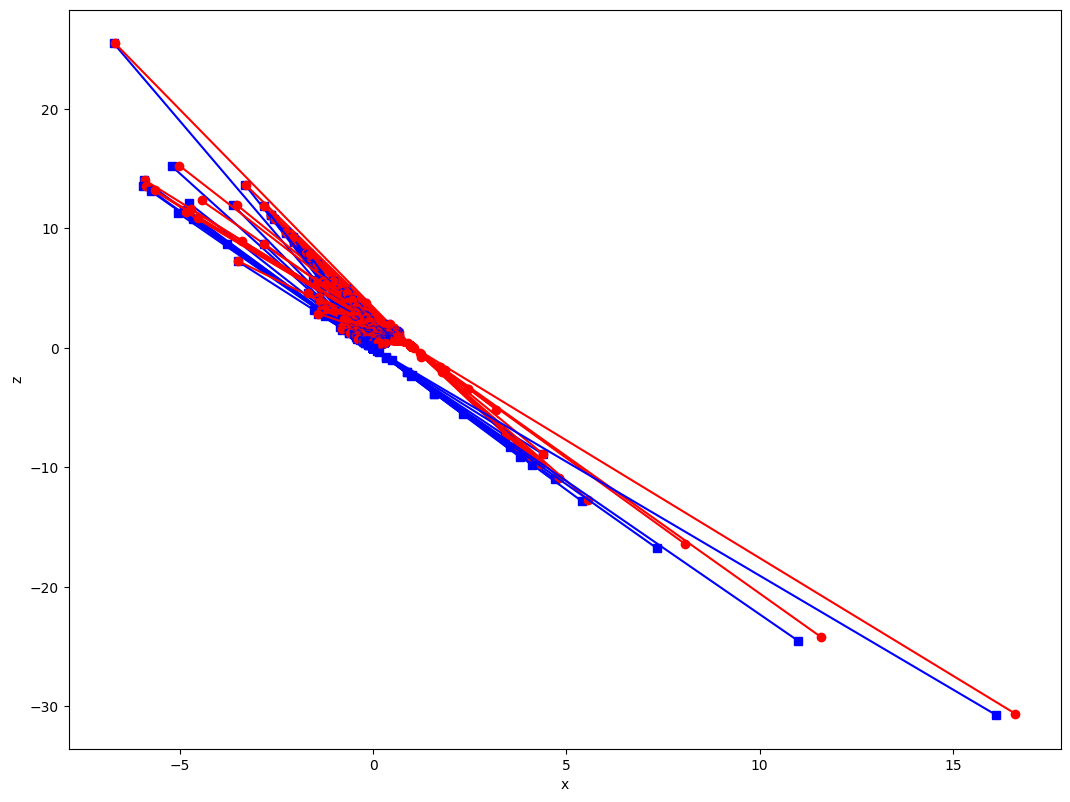

In [48]:
from recon3d import reconstruct3D 

P1, P2, T, R = reconstruct3D(transform_candidates, calibrated_1, calibrated_2)

plot_reconstruction(P1, P2, T, R)

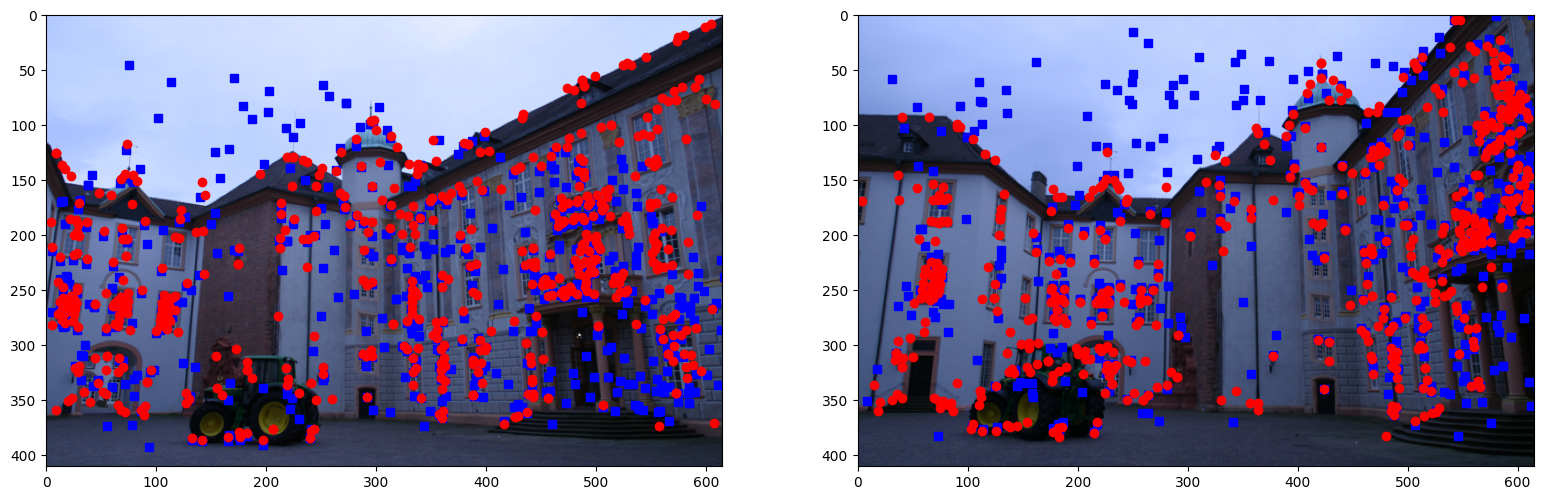

In [52]:
from show_reproj import show_reprojections

show_reprojections(images[0], images[1], uncalibrated_1, uncalibrated_2, P1, P2, K, T, R)

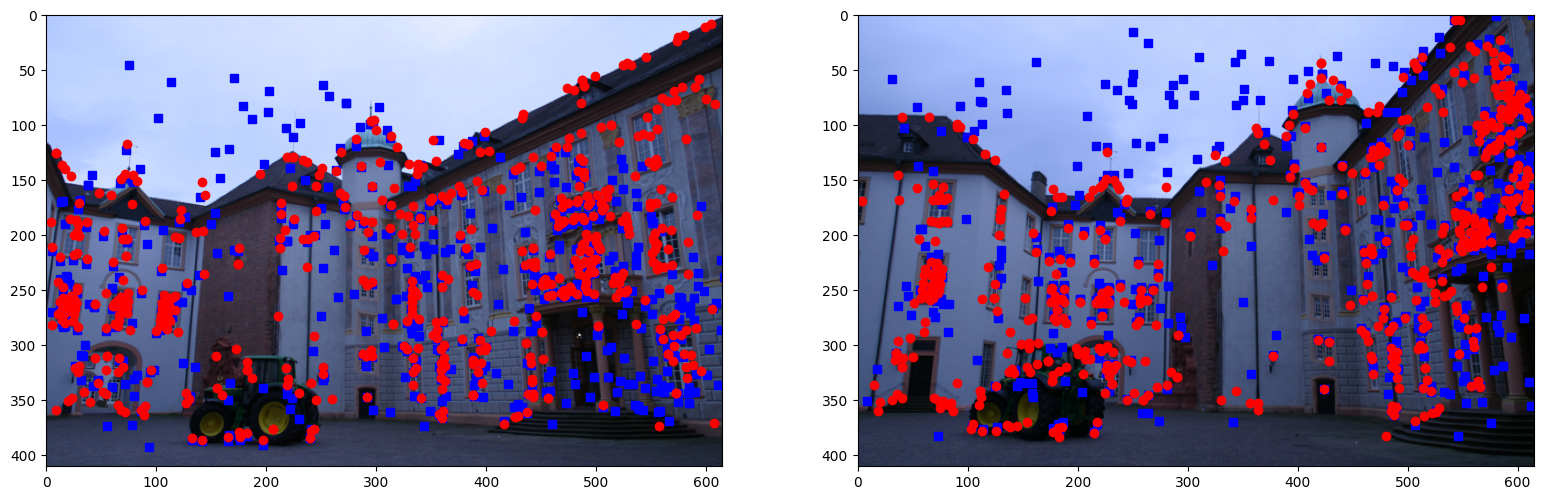

In [53]:
show_reprojections(images[0], images[1], uncalibrated_1, uncalibrated_2, P1, P2, K, T, R)